# Overview
- ModelCheckpoint: save model while training
- EarlyStopping: stop training early to avoid overfitting
- ReduceLROnPlateau: reduce learning rate while training
- TensorBoard: plot training and validation metrics

# Import libraries

In [1]:
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

# Training utilities
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model

import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_classes = 2   # male vs. female

# (1) Data

### Download data at https://drive.google.com/drive/folders/0BxINLo5jshCRYW8xODhNSlkyLTQ?resourcekey=0-RNJvvSSE67Q1bMqQi3A1RQ&usp=sharing
This source code and npy files MUST be in the same location

In [3]:
x_train = np.load('/kaggle/input/human-gender1/64_64_11938_4098_train_x_onehot.npy')
y_train = np.load('/kaggle/input/human-gender1/64_64_11938_4098_train_y_onehot.npy')
x_train = np.rot90(x_train, k=3, axes=(1, 2))

x_test = np.load('/kaggle/input/human-gender1/64_64_5968_4098_val_x_onehot.npy')
y_test = np.load('/kaggle/input/human-gender1/64_64_5968_4098_val_y_onehot.npy')
x_test = np.rot90(x_test, k=3, axes=(1, 2))

# (2) Declare model

In [4]:
# 64x64 portray image
input_image = Input(shape=(64, 64, 1), name='Input')

# conv, pooling layers + dropout
x = Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', name='conv1_1')(input_image)
x = Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', name='conv1_2')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool1')(x)
x = Dropout(rate=0.2, name='conv_dropout1')(x)

x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', name='conv2_1')(x)
x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', name='conv2_2')(x)
x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', name='conv2_3')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool2')(x)
x = Dropout(rate=0.2, name='conv_dropout2')(x)

x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv3_1')(x)
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv3_2')(x)
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv3_3')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool3')(x)
x = Dropout(rate=0.2, name='conv_dropout3')(x)

x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv4_1')(x)
x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv4_2')(x)
x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv4_3')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool4')(x)
x = Dropout(rate=0.2, name='conv_dropout4')(x)

x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='conv5_1')(x)
x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='conv5_2')(x)
x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='conv5_3')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool5')(x)
x = Dropout(rate=0.2, name='conv_dropout5')(x)

# similar to the MLP example!
# matrix ---> vector
x = Flatten(name='flatten')(x)

# FC layers + dropout
x = Dense(units=1024, activation='relu', name='fc1')(x)
x = Dropout(rate=0.2, name='fc_dropout1')(x)

x = Dense(units=1024, activation='relu', name='fc2')(x)
x = Dropout(rate=0.2, name='fc_dropout2')(x)

output_label = Dense(units=num_classes, activation='softmax', name='fc3_10ways_softmax')(x)

# define model
model = Model(inputs=input_image, outputs=output_label, name='mnist_mlp')

# print model summary
model.summary()

Model: "mnist_mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_1 (Conv2D)                     │ (None, 64, 64, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_2 (Conv2D)                     │ (None, 64, 64, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dropout1 (Dropout)              │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_1 (Conv2D)                     │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_2 (Conv2D)                     │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_3 (Conv2D)                     │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dropout2 (Dropout)              │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3_1 (Conv2D)                     │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3_2 (Conv2D)                     │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3_3 (Conv2D)                     │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling2D)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dropout3 (Dropout)              │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4_1 (Conv2D)                     │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4_2 (Conv2D)                     │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4_3 (Conv2D)                     │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool4 (MaxPooling2D)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dropout4 (Dropout)              │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv5_1 (Conv2D)                     │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,063,570 (15.50 MB)

 Trainable params: 4,063,570 (15.50 MB)

 Non-trainable params: 0 (0.00 B)

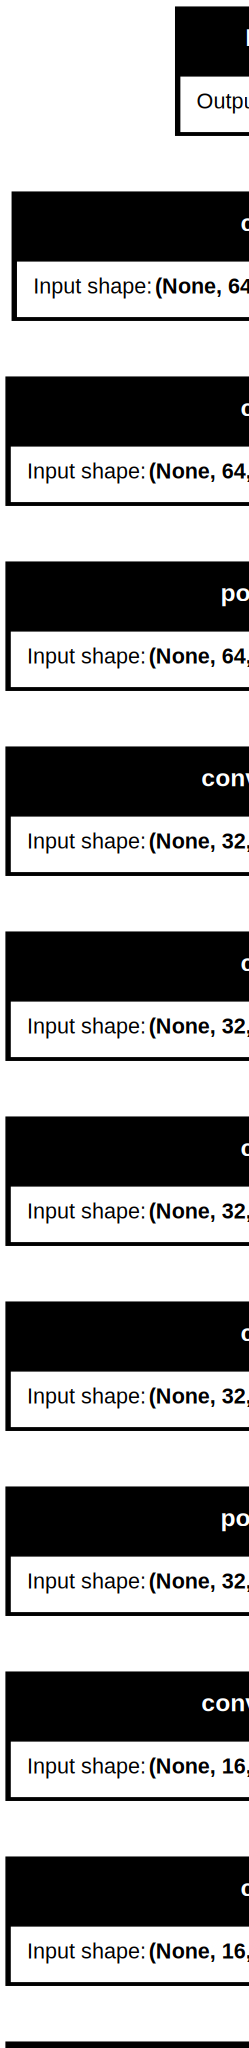

In [5]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# (3) Train defined model
- Note that the training history including loss and accuracy will be save in 'history' variable
- In case your system runs out of memory (OOM), try to decrease batch size

In [6]:
# Khai báo learning rate, loss function, và metric
loss = 'categorical_crossentropy'
learning_rate = 0.001
model.compile(loss=loss, optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

# Train model
batch_size = 128
epochs = 100000  # Sử dụng EarlyStopping nên có thể đặt lớn

# ===============================
#      Training utilities
# ===============================
# ModelCheckpoint: Lưu model tốt nhất
check_pointer = ModelCheckpoint(
    filepath='best_model.keras',  # Lưu cố định file model tốt nhất
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

# EarlyStopping: Dừng sớm nếu không cải thiện
early_stopping_after_epochs = 5
early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_after_epochs, mode='min')

# ReduceLROnPlateau: Giảm learning rate nếu không cải thiện
reduce_lr_after_epochs = 5
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=reduce_lr_after_epochs, min_lr=0.0001, mode='min')

# TensorBoard để hiển thị log
tf_board = TensorBoard(log_dir='./logs')

# Huấn luyện mô hình
starting_time = time.time()
model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[check_pointer, early_stopping, reduce_lr, tf_board])

print('> Training time is %.4f minutes' % ((time.time() - starting_time) / 60))


Epoch 1/100000
94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 150ms/step - accuracy: 0.7793 - loss: 1.0780 - val_accuracy: 0.7885 - val_loss: 0.5090 - learning_rate: 0.0010
Epoch 2/100000
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7864 - loss: 0.5158 - val_accuracy: 0.7885 - val_loss: 0.5078 - learning_rate: 0.0010
Epoch 3/100000
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7899 - loss: 0.5000 - val_accuracy: 0.7874 - val_loss: 0.4831 - learning_rate: 0.0010
Epoch 4/100000
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7883 - loss: 0.4923 - val_accuracy: 0.8076 - val_loss: 0.4651 - learning_rate: 0.0010
Epoch 5/100000
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8017 - loss: 0.4700 - val_accuracy: 0.8058 - val_loss: 0.4571 - learning_rate: 0.0010
Epoch 6/100000
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8090 - loss: 0.4629 - val_accuracy: 0.8102 - val_loss: 0.4507 - learning_rate: 0.0010
Epoch 7/100000
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0

### Training time
- Training time with GTX 1080 is about 3.1879 minutes for 32 epochs
- Validation accuracy is ~87.7% at epoch #27. Without training utilities, the best accuracy should be ~82.6%

### Load trained model and evaluate it again with validation set

In [7]:
model.load_weights('best_model.keras')
model.evaluate(x_test, y_test)

187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9479 - loss: 0.1857


[0.32641178369522095, 0.8783512115478516]

### Checkpoint files

In [8]:
# cp = plt.imread('checkpoints.PNG')
# plt.figure(figsize=(15, 10))
# plt.imshow(cp)
# plt.show()

### TensorBoard

In [9]:
# cp = plt.imread('tfboard.PNG')
# plt.figure(figsize=(16, 13))
# plt.imshow(cp)
# plt.show()

# (4) Evaluate trained model

In [10]:
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9479 - loss: 0.1857
Test loss: 0.32641178369522095
Test accuracy: 0.8783512115478516


In [11]:
def int2gender(num):
    if num == 0:
        return 'female'
    else:
        return 'male'

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


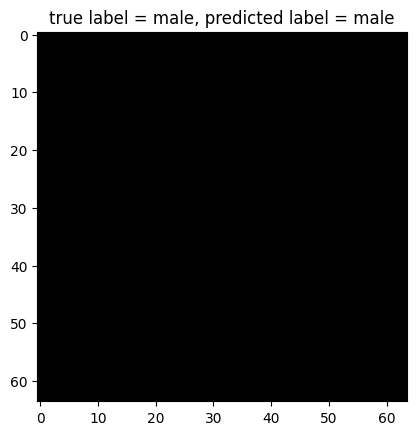

In [12]:
# select a test image randomly
random_test_index = np.random.choice(x_test.shape[0], size=1)[0]
test_img = x_test[random_test_index]
test_label = np.argmax(y_test[random_test_index])

# predict test image with trained model
pred_label = model.predict(np.expand_dims(test_img, axis=0))
pred_label = np.argmax(pred_label)

plt.imshow(test_img[:, :, 0], cmap='gray')
plt.title('true label = %s, predicted label = %s' % (int2gender(test_label), int2gender(pred_label)))
plt.show()